<a href="https://colab.research.google.com/github/Taedriel/ZSL-v2/blob/googleImageFSL/pipeline_01_07(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#---INSTALL---

In [ ]:
!yes | pip install -U --quiet selenium scikit-learn-intelex Pillow sklearn
!cd "./drive/MyDrive/Colab Notebooks/pipeline" && pip install -r --quiet requirements.txt

!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin
import sys
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')

     |████████████████████████████████| 981 kB 34.5 MB/s 
     |████████████████████████████████| 87 kB 7.3 MB/s 
     |████████████████████████████████| 3.1 MB 55.8 MB/s 
     |████████████████████████████████| 358 kB 74.1 MB/s 
     |████████████████████████████████| 139 kB 18.4 MB/s 
     |████████████████████████████████| 55 kB 4.2 MB/s 
     |████████████████████████████████| 4.1 MB 55.7 MB/s 
     |████████████████████████████████| 58 kB 6.3 MB/s 
     |████████████████████████████████| 26.0 MB 1.2 MB/s 
     |████████████████████████████████| 300.3 MB 19 kB/s 
     |████████████████████████████████| 4.0 MB 55.4 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
requests 2.23.0 requires urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you have urllib3 1.26.10 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which 

#--- CONSTANT DEFINITION AND IMPORT ---

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os, itertools, shutil, requests, webbrowser, urllib.request, time, random, gc, re
import PIL.Image
from matplotlib.patches import Rectangle

from math import trunc

from IPython.core.display import Image
from statistics import mean, pstdev
from selenium import webdriver
from bs4 import BeautifulSoup 

import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import transforms, utils
from torchvision.models import resnet18, resnet50
from sklearn.metrics import classification_report, confusion_matrix
from scipy import ndimage, misc
import imageio

from tqdm import tqdm

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.10) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [ ]:
PATH = "/content/drive/MyDrive/Colab Notebooks/pipeline/"
PATH_IMAGES = "/content/drive/MyDrive/Colab Notebooks/pipeline/images/"
PATH_MODEL = "/content/drive/MyDrive/Colab Notebooks/pipeline/model/"

globalSize = 20
LEN_FOR_ONE_SCROLL = 20

N_WAY = 5
N_SHOT = 5
N_QUERY = 15

batchSize = 125

showDataClean, showDataTrain = True, False

In [ ]:
gc.collect()

109

#--- UTILS ---

In [ ]:
def createListOfClasses(classesFile, searchPrecision=""):

  """
  get set of all classes to be used in the support set from Ismael's text file
  """

  classes = []
  index=0

  for animal in classesFile.readlines():
    animal = animal.strip("\n").replace(" ", "")
    classes.append(animal + searchPrecision)

  return classes

In [ ]:
def getUa(mesurements, k=1):

  """
  get mean and incertitude from a list of mesurements, the first element in the list
  must be the title of the experiement.
  """

  title = mesurements[0]
  l = mesurements[1:]
  inv_n = 1.0/(len(l)-1)
  inv_ns = 1.0/pow(len(l), 0.5)
  m_ = round(mean(l), 2)
  dm2 = [pow(mi - m_, 2) for mi in l]
  pstd = pow(inv_n*sum(dm2), 0.5)
  u = round(k*pstd*inv_ns, 2)
  
  return title+str(m_) + "% +- " + str(u) + " (with 95% confidence)" if k!=1 else "", m_, u

def getUaList(listOfExperiences, k=1):

  for mesurements in listOfExperiences:
    string, m_, u = getUa(mesurements, k)
    print(string)

In [ ]:
def getOnlyImages(set_):
  
  justSet = []
  for class_ in set_:
    for image in class_:
      justSet.append(image[0])

  return torch.stack(justSet)

def plot_images(images, title, images_per_row):
  plt.figure()
  plt.title(title)
  plt.imshow(utils.make_grid(images, nrow=images_per_row).permute(1, 2, 0))

In [ ]:
def saveFile(filename, data):
  file = open(PATH_MODEL+filename, "w+")
  for d in data:
    file.write(str(d)+"\n")
  file.close()

def showRegression(rangeOfData, data, degree):
  coef = np.polyfit(rangeOfData, data, degree)
  poly1d_fn = np.poly1d(coef) 
  plt.plot(rangeOfData, data, '-yo', rangeOfData, poly1d_fn(rangeOfData), '--k')
  plt.show()
  print("regression polynome :\n")
  print(np.poly1d(poly1d_fn))
  print("started at", data[0], "and ended at", data[-1])
  print("\n")

def showData(data, title, degree, saveInfo=[False, ""]):

  path = saveInfo[1]
  if saveInfo[0]:
    saveFile(path, data)

  numberOfIteration = range(0, len(data))

  plt.plot(numberOfIteration, data)
  plt.title(title)
  plt.show()
  showRegression(numberOfIteration, data, degree)

In [ ]:
def getMatrixReport(labels, predicted_labels):
    print("\n")
    listOfClasses = list(dict.fromkeys(labels))
    res = classification_report(labels, predicted_labels, target_names=["c"+str(i) for i in range(1, len(listOfClasses)+1)],  output_dict=True)
    return res, res['accuracy'], confusion_matrix(labels, predicted_labels)

In [ ]:
def numberInInterval(interval, range_):
  in_ = 0
  minX = range_[0]
  maxX = range_[1]
  for x in interval:
    if x >= minX and x < maxX:
      in_+=1
    
    if x == 1 and maxX == 1:
      in_+=1

  return in_

def getDistributionOnPred(correctPredictions, bins):
  NumberDist = []
  for elem in bins:
    NumberDist.append(100*numberInInterval(correctPredictions, elem)/len(correctPredictions))

  return NumberDist

def createHistogramPreds(predictions, title):

  bins = [(i*0.1, (i+1)*0.1) for i in range(0, 10)]
  NumberDist = getDistributionOnPred(predictions, bins)

  fig, ax = plt.subplots()
  for i, percentage in enumerate(NumberDist):
    ax.add_patch(Rectangle((0.1*i, 0), 0.1, percentage, edgecolor='black'))
  plt.ylim(int(max(NumberDist))+2)
  plt.gca().invert_yaxis()
  plt.xlabel(title)
  plt.ylabel("number of predictions in %")
  plt.show()

  return NumberDist

In [ ]:
def getSimilarityDistributions(dist, threshold):
  dist1 = []
  dist2 = []

  for x in dist:
    if x > threshold:
      dist2.append(x)
    else:
      dist1.append(x)

  return dist1, dist2

def getR(dist1, dist2):

  L1, L2 = len(dist1), len(dist2)
  return L2/L1 if L1 != 0 else -1

def printDistributions(dist, threshold):

  dist1, dist2 = getSimilarityDistributions(dist, threshold)
  L1, L2 = len(dist1), len(dist2)
  r = getR(dist1, dist2)
  
  print("r (L2/L1) = ", r if r > 0 else "+inf")
  plt.hist(dist1,bins=10)
  plt.hist(dist2,bins=10)
  plt.show()

In [ ]:
def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]

#--- IMAGE RETRIEVAL FUNCTIONS ---

In [ ]:
"""
thumbnail / jpg (compression) may be an issue
"""

def getParser(classeName):

  site = 'https://www.google.com/search?tbm=isch&q='+classeName

  chrome_options = webdriver.ChromeOptions()
  chrome_options.add_argument('--headless')
  chrome_options.add_argument('--no-sandbox')
  chrome_options.add_argument('--disable-dev-shm-usage')

  driver = webdriver.Chrome('chromedriver', options=chrome_options)
  driver.get(site)
  driver.execute_script("window.scrollBy(0, document.body.scrollHeight)")
  soup = BeautifulSoup(driver.page_source, 'html.parser')
  driver.close()

  return soup

In [ ]:
def getClassImages(path, classeName):
  
  imagesNumber = 0
  soup = getParser(classeName)
  img_tags = soup.find_all("img", class_="rg_i")

  for index in range(0, len(img_tags)):
    try:
        urllib.request.urlretrieve(img_tags[index]['src'], path+classeName+"/"+str(classeName+str(index))+".jpg")
        imagesNumber+=1
    except Exception as e:
        pass

  return imagesNumber

def getImagesGoogle(classes):

  imagesNumber = 0
  shutil.rmtree(PATH_IMAGES, ignore_errors=False)
  os.makedirs(PATH_IMAGES)

  print("downloading images...")

  for classe in tqdm(classes):

    try:
      classeName = classe.replace(" ", "")
      os.makedirs(PATH_IMAGES+classeName)
      imagesNumber += getClassImages(PATH_IMAGES, classeName)
    except:
      pass

  return imagesNumber

In [ ]:
def getClassesImagesURLLIB(classes, download=True):

  imagesNumber = 0

  if download:
    imagesNumber = getImagesGoogle(classes)
  
  print("\n"+str(imagesNumber) + " images were downloaded. " + str(imagesNumber/len(classes)) + " per classes")

#--- DATASET ---

##--- Base functions ---

In [ ]:
def getNrandomClassesPaths(path, listClasses, n_way):

  if n_way == len(listClasses):
    return listClasses

  paths = []
  for i in range(0, n_way):
    ridx = random.randint(0, len(listClasses)-1)
    paths.append(path+listClasses[ridx]+"/")
    listClasses.remove(listClasses[ridx])

  return paths

In [ ]:
imageResize = (224, 224)

def getImageTensor(path):
  convertCUBLike = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0, 0, 0), (1, 1, 1))
                              ])
  convertOmni = transforms.Compose([
                                transforms.Grayscale(num_output_channels=3),
                                transforms.ToTensor(),
                                transforms.Normalize((0, 0, 0), (1, 1, 1))
                              ])
  
  return convertCUBLike(PIL.Image.open(path).resize(imageResize))

##--- For cleaning ---

In [ ]:
class MetaSet:

  def __init__(self):
    """
    the lenght parameter is here in order to avoid testing the query against
    unrelated images
    """
    self.supportSetMatrix = []
    self.querySetMatrix = []
    self.supportLenghtMatrix = []
    self.imageNameSetMatrix = []
    self.buffer = [[], [], []]

  def __call__(self, i, j):
    return (self.supportSetMatrix[i][j], self.querySetMatrix[i][j], 
            self.supportLenghtMatrix[i][j])

  def lenght(self):
    rows = len(self.supportSetMatrix)
    columns = len(self.supportSetMatrix[0]) if self.supportSetMatrix != [] else 0 

    return rows, columns

  def clearBuffer(self):
    self.buffer = [[], [], []]

  def addToBuffer(self, arrayOfValue):
    for index in range(0, 3):
      self.buffer[index].append(arrayOfValue[index])

  def setLine(self):
    self.supportSetMatrix.append(self.buffer[0])
    self.querySetMatrix.append(self.buffer[1])
    self.supportLenghtMatrix.append(self.buffer[2])
    self.clearBuffer()

In [ ]:
class CleaningSetProvider:

  def __init__(self, pathToImage, numberOfPositives, numberOfNegatives):
    self.pathToNegatives = "/content/drive/MyDrive/Colab Notebooks/pipeline/ImageNetFetched/"
    self.path = pathToImage
    self.nbNegative = numberOfNegatives
    self.nbPositive = numberOfPositives

  def getListOfImagesResized(self, path):
    images = os.listdir(path)
    images.sort(key=natural_keys)
    images = images[0:self.nbPositive]

    return images

  def addNegativeExamples(self, pathToClass, label, supportSet):

    images = os.listdir(pathToClass)
    for i in range(0, self.nbNegative):
      supportSet.append((getImageTensor(pathToClass+images[i]), label))

    return supportSet

  def addNegativeClasses(self, supportSet):

    negativeClasses = os.listdir(self.pathToNegatives)
    for i in range(0, len(negativeClasses)):
      supportSet = self.addNegativeExamples(self.pathToNegatives+negativeClasses[i]+"/", i+1, supportSet)

    return supportSet

  def getFolderTensorsForCleaning(self, pathToClass, label, q_index):

    images = self.getListOfImagesResized(pathToClass)
    originalLenght = len(images)

    query = (getImageTensor(pathToClass+images[q_index]), label)
    images.remove(images[q_index])

    support = []
    for image in images:
      support.append((getImageTensor(pathToClass+image), label))
    
    support = self.addNegativeClasses(support)

    return [support, query, originalLenght]

  def getSetOfCleaningSets(self, listClasses):

    meta_set = MetaSet()
    for class_ in listClasses:

      listEx = self.getListOfImagesResized(self.path+class_)
      for q_index in range(0, len(listEx)):
        oneElement = self.getFolderTensorsForCleaning(self.path+class_+"/", 0, q_index)
        meta_set.addToBuffer(oneElement)

      meta_set.setLine()
      meta_set.imageNameSetMatrix.append([self.path+class_+"/"+image for image in listEx])

    return meta_set

##--- For training in FSL ---

In [ ]:
# each set is as follows : 
"""
[
  [(I, c), (I, c), ..., (I, c), (I, c)],
  [(I, c), (I, c), ..., (I, c), (I, c)],
   .          .                    .
   .            .                  .
   .              .                .
   .                .              .
                      .            .
  [(I, c), (I, c), ..., (I, c), (I, c)]
]
"""
 

def getFolderTensorsForTraining(path, supportNumber, queryNumber, label):

  images = os.listdir(path)
  images.sort(key=natural_keys)
  support_i, query_i = [], []

  for i in range(0, supportNumber):
    ridx = random.randint(0, len(images)-1)
    support_i.append( (getImageTensor(path+images[ridx]), label) )
    images.remove(images[ridx])
  
  for i in range(0, queryNumber):
    ridx = random.randint(0, len(images)-1)
    query_i.append( (getImageTensor(path+images[ridx]), label) )
    images.remove(images[ridx])

  return support_i, query_i

def getSets(paths, supportNumber, queryNumber):

  supportSet, querySet = [], []
  for label, path in enumerate(paths):
    Si, Qi = getFolderTensorsForTraining(path, supportNumber, queryNumber, label)
    supportSet.append(Si)
    querySet.append(Qi)

  return supportSet, querySet

##--- PAIR GENERATION ---

In [ ]:
def getIndexes(setOfImages, nbClasses, cleaning=False):

  nbEx =  len(setOfImages) if cleaning else len(setOfImages[0])
  ci1, e1 = random.randint(0, nbClasses-1), random.randint(0, nbEx-1) 
  ci2, e2 = random.randint(0, nbClasses-1), random.randint(0, nbEx-1)

  return ci1, ci2, e1, e2

def getRandomPair(setOfImages, cleaning=False):

  nbClasses = len(setOfImages)
  ci1, ci2, e1, e2 = getIndexes(setOfImages, nbClasses, cleaning)
  
  I1, I2, s = 0, 0, 0
  if cleaning:
      c1, c2 = setOfImages[e1][1], setOfImages[e2][1]
      I1, I2 = torch.stack([setOfImages[e1][0]]), torch.stack([setOfImages[e2][0]])
      s = 1.0 if c1 == c2 else 0.0
  else:
    I1, I2 = torch.stack([setOfImages[ci1][e1][0]]), torch.stack([setOfImages[ci2][e2][0]])
    s = 1.0 if ci1 == ci2 else 0.0

  return I1, I2, s

#--- NETWORK ---

## --- Utils ---

In [ ]:
class ModelUtils:

  def __init__(self):
    pass

  def getOptimizer(self, model):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    return optimizer
  
  def getImages(self, image1, image2):

    if image1.dim() < 4:
      image1 = image1.unsqueeze(0)
    
    if image2.dim() < 4:
      image2 = image2.unsqueeze(0)

    return image1, image2

  def resetModel(self, model):

    for layer in model.children():
      if hasattr(layer, 'reset_parameters'):
        layer.reset_parameters()

    return model

In [ ]:
class ModelSaver:

  def __init__(self, path):
    self.PATH_MODEL = path

  def saveModel(self, name, model_opti, epoch, loss_value):

    model, optimizer = model_opti[0], model_opti[1]

    torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss_value
    }, self.PATH_MODEL+name)

  def loadModel(self, model_name, model_opti):

    model, optimizer = model_opti[0], model_opti[1]

    checkpoint = torch.load(self.PATH_MODEL+model_name)
    model.load_state_dict(checkpoint['model_state_dict'])  
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch_ = checkpoint['epoch']
    loss_ = checkpoint['loss']

    return (epoch_, loss_), [model, optimizer]

##--- Models ---

In [ ]:
cuda_ = True
enter = 2048
hidden = 1024

metricCleaning = nn.Sequential(nn.Linear(enter, hidden), nn.ReLU(),
                               nn.Linear(hidden, 1)) 

metric = nn.Sequential(nn.Linear(enter, hidden), nn.ReLU(),
                       nn.Linear(hidden, hidden), nn.ReLU(),
                       nn.Linear(hidden, hidden), nn.ReLU(),
                       nn.Linear(hidden, 1)) 

In [ ]:
class Siamese(nn.Module):

  """
  I1 --> CNN --> u
                  \
                    |u-v| --> NN --> x --> s(x) --> L(.,.)
                  /
  I2 --> CNN --> v
  """

  def __init__(self, modules, metric, cuda_):
    super(Siamese, self).__init__()
    
    self.cuda_ = cuda_
    self.backbone = nn.Sequential(*modules).cuda() if cuda_ else nn.Sequential(*modules)
    self.metric = metric.cuda() if cuda_ else metric
    self.combination = lambda u, v: torch.abs(u-v)      

  def get_vector(self, image):
    image = image.cuda() if self.cuda_ else image
    return torch.flatten(self.backbone(image))

  def createCombinedVector(self, I1, I2):
    u = self.get_vector(I1)
    v = self.get_vector(I2)
    return self.combination(u, v)

  def forward(self, w):
    out = self.metric(w)
    out_normalized = torch.sigmoid(out)

    return out_normalized

In [ ]:
backbone = resnet50(pretrained=True)
modules=list(backbone.children())[:-1]

if cuda_:
  modelCleaning = Siamese(modules, metricCleaning, cuda_).cuda()
  model = Siamese(modules, metric, cuda_).cuda()

else:
  modelCleaning = Siamese(modules, metricCleaning, cuda_)
  model = Siamese(modules, metric, cuda_)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

#--- TRAINING CLASS ---

In [ ]:
class Trainer(ModelUtils):

  def __init__(self, path_model, model, cleaning):

    super().__init__()
    self.cleaningPhase = cleaning
    self.model = model
    self.optimizer = super().getOptimizer(model)
    self.LOSS = nn.BCELoss()

    self.model_saver = ModelSaver(path_model)

  def epoch(self, suppSet):

    lossForBatch = []
    for i in range(0, batchSize):

      I1, I2, s = getRandomPair(suppSet, self.cleaningPhase)

      I1, I2 = super().getImages(I1, I2)
      w = self.model.createCombinedVector(I1, I2)
      out = self.model(w)
      s = torch.tensor([s]).cuda() if cuda_ else torch.tensor([s])

      self.optimizer.zero_grad()
      loss = self.LOSS(out, s)
      loss.backward()
      self.optimizer.step()
      lossForBatch.append(loss.item())

    return lossForBatch


  def training(self, supportSet, epoch_loss=(0, 0), set_i=0):

    numberOfEpochs = 70-epoch_loss[0]
    valFreq = 10

    losses = [epoch_loss[1]] if epoch_loss[1] != 0 else []
    
    self.model.train()
    for epoch_i in tqdm(range(0, numberOfEpochs), desc="Traning on Set "+str(set_i)):

      batchLoss = self.epoch(supportSet)
      mean_loss = sum(batchLoss)*1.0/len(batchLoss)
      losses.append(mean_loss)

      if epoch_i % valFreq == 0 and epoch_i != 0:
        model_opti =  [self.model, self.optimizer]
        self.model_saver.saveModel("SNTrain.pt", model_opti, epoch_i, mean_loss)

    torch.save(self.model.state_dict(), PATH_MODEL+"SN.pt")

    return losses

In [ ]:
saveBaseModel = True
if saveBaseModel:

  saver = ModelSaver(PATH_MODEL)
  t = Trainer(PATH_MODEL, modelCleaning, False)

  saver.saveModel("SNForCleaning.pt", [t.model, t.optimizer], 0, 0)

#--- TESTING CLASS ---

In [ ]:
class Tester(ModelUtils):

  def __init__(self, model):
    super().__init__()
    self.model = model


  def getFirstClassBasedOnRepresentation(self, predictions):

    representation = [0]*N_WAY
    for pred in predictions:
      representation[pred[0]] += 1

    return representation.index(max(representation))


  def isCorrect(self, predictions, queryClass):

    pred_sorted = sorted(predictions, key=lambda tup: tup[-1], reverse=True)
    first_five = pred_sorted[0:5]

    predictedClassLabel = self.getFirstClassBasedOnRepresentation(first_five)
    similarity = int(queryClass == predictedClassLabel)
    predictionScore = first_five[0][1]

    return similarity, predictedClassLabel, predictionScore

  
  def model_prediction(self, queryInfo, imageInfo, triplets):

    image, imageClass = imageInfo
    query, queryClass = queryInfo

    query, image = super().getImages(query, image)
    w = self.model.createCombinedVector(query, image)
    p = self.model(w)
    triplets.append((imageClass, p))

    areReallySimilar, imageClass, prediction = self.isCorrect(triplets, queryClass)

    return triplets, areReallySimilar, imageClass, prediction


  def evaluateWithMetric(self, supportSet, querySet):

    triplets = []
    pred_labels = []
    query_labels = []
    correctPreds, incorrectPreds = [], []
    correct = 0
    
    self.model.eval()
    with torch.no_grad():

      for indexQuery, queryInfo in enumerate(list(itertools.chain(*querySet))):

        _, queryClass = queryInfo
        for imageInfo in list(itertools.chain(*supportSet)):
          triplets, areReallySimilar, imageClass, prediction = self.model_prediction(queryInfo, imageInfo, triplets)
          
        if areReallySimilar == 1: 
          correct+=1
          correctPreds.append(prediction)
        else:
          incorrectPreds.append(prediction)

        triplets = []
        pred_labels.append(imageClass)
        query_labels.append(queryClass)

    return "\n accuracy :"+str(100.0*correct/(N_WAY*N_QUERY)), pred_labels, query_labels, correctPreds, incorrectPreds


  def queryEvaluation(self, supportSet, querySet):

    triplets = []
    self.model.eval()
    with torch.no_grad():

      query, queryClass = querySet
      for imageInfo in list(itertools.chain(*supportSet)):

        image, imageClass = imageInfo
        query, image = super().getImages(query, image)
        w = self.model.createCombinedVector(query, image)
        p = self.model(w)
        triplets.append((imageClass, p))
      
    pred_sorted = sorted(triplets, key=lambda tup: tup[-1], reverse=True)
    first_five = pred_sorted[0:5]
    predictedClassLabel = self.getFirstClassBasedOnRepresentation(first_five)

    return predictedClassLabel

#--- CLEANING CLASS --- 

In [ ]:
from pathlib import Path
"""
falseEx = self.getDissimilarImages(meta_set.imageNameSetMatrix[i], preds, self.threshold)
printDistributions(preds, 0.5)
self.printDissimilarImages(Eij[1][0], falseEx)

  def getDissimilarImages(self, pathMatrix, predictionMatrix, e):

    res = []
    for ai, pi in zip(pathMatrix, predictionMatrix):
      if pi < e: 
        res.append(ai)
    
    return res

  def printDissimilarImages(self, Qij, falseEx):

    falseFolder = [Qij]
    for imagePath in falseEx:
      falseFolder.append(getImageTensor(imagePath))

    plot_images(falseFolder, "Query + dissimilar Images", images_per_row=len(falseFolder))
"""

class Cleaner(ModelUtils):

  def __init__(self, path_model, model, meta_set):
    super().__init__()

    self.meta_set = meta_set
    self.threshold = 0.6

    self.model_t = Trainer(path_model, model, True)
    self.model_saver = ModelSaver(path_model)

    self.falseVector = []
    self.trueVector = []

  def isQueryOutsider(self, Eij):

    model = self.model_t.model
    supportSet, querySet, lenght = Eij[0], Eij[1], Eij[2]-1
    preds = []

    model.eval()
    with torch.no_grad():

      query_raw = querySet[0]
      for image_raw, imageClass in supportSet[:lenght]:
        query, image = self.model_t.getImages(query_raw, image_raw)
        w = model.createCombinedVector(query, image)
        p = model(w)
        preds.append(p.cpu().item())
      
    return preds

  def getPredictionsForOneQuery(self, Eij, indexSet):

    _, model_opti = self.model_saver.loadModel("SNForCleaning.pt", [self.model_t.model, self.model_t.optimizer])
    self.model_t.model, self.model_t.optimizer = model_opti[0], model_opti[1]
    
    self.model_t.training(Eij[0], set_i=indexSet) 
    preds = self.isQueryOutsider(Eij)

    return preds

  def decideOnImageType(self, indices, Qij, r, imageToClean):

    tmp = imageToClean
    if 0 <= r < 1:
      self.falseVector.append(Qij)
      tmp.append(meta_set.imageNameSetMatrix[indices[0]][indices[1]]) 
    else:
      self.trueVector.append(Qij)

    return tmp

  def showSeparation(self):

    if self.falseVector != []:
      falseTensor = torch.stack(self.falseVector)
      plot_images(falseTensor, "Images To Clean", images_per_row=len(self.falseVector))

    if self.trueVector != []:
      trueTensor = torch.stack(self.trueVector)
      plot_images(trueTensor, "Images to keep", images_per_row=len(self.trueVector))

  def cleanSets(self):

    threshold = 0.6
    pathToRemove = []
    rList = []
    
    rows, columns = self.meta_set.lenght()    
    for i in range(0, rows):

      SetPredictions = []
      self.falseVector, self.trueVector = [], []
      for j in range(0, columns):

        Eij = [*meta_set(i, j)]
        preds = self.getPredictionsForOneQuery(Eij, i)

        distFalse, distTrue = getSimilarityDistributions(preds, threshold)
        r = getR(distFalse, distTrue)
        rList.append(r)
        pathToRemove = self.decideOnImageType((i, j), Eij[1][0], r, pathToRemove)

      print(rList)
      self.showSeparation()

      #clean

#--- PATH DEFINITION ---

In [ ]:
CUB, IMAGES, OMNIGLOT = False, True, False
PATH_DATA = ""
listClass = []

# a simplifier + tard quand j'aurais + qu'un path
if CUB or IMAGES:
  PATH_DATA = "/content/drive/MyDrive/Colab Notebooks/pipeline/model/data/CUB/images/" if CUB else "/content/drive/MyDrive/Colab Notebooks/pipeline/images/"
  listClass = os.listdir(PATH_DATA)
elif OMNIGLOT:
  PATH_DATA = "/content/drive/MyDrive/Colab Notebooks/pipeline/model/dataO/omniglot-py/images_background/" 
  listAlphabet = os.listdir(PATH_DATA)
  choosenAlphabet = listAlphabet[random.randint(0, len(listAlphabet)-1)]
  listClass = [choosenAlphabet+"/"+char for char in os.listdir(PATH_DATA+choosenAlphabet)]

#--- TRAIN AND TEST ---

In [ ]:
supportClasses = getNrandomClassesPaths(PATH_DATA, listClass, N_WAY)
print(supportClasses)
supportSet, querySet = getSets(supportClasses, N_SHOT, N_QUERY)

['/content/drive/MyDrive/Colab Notebooks/pipeline/images/Ape/', '/content/drive/MyDrive/Colab Notebooks/pipeline/images/Antelope/', '/content/drive/MyDrive/Colab Notebooks/pipeline/images/Africanbuffalo/', '/content/drive/MyDrive/Colab Notebooks/pipeline/images/Anteater/', '/content/drive/MyDrive/Colab Notebooks/pipeline/images/Alpaca/']


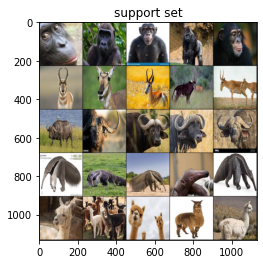

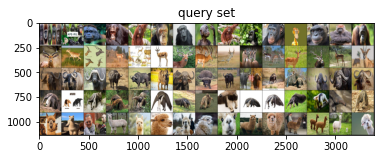

In [ ]:
justSupport = getOnlyImages(supportSet)
justQuery = getOnlyImages(querySet)
plot_images(justSupport, title="support set", images_per_row=N_SHOT)
plot_images(justQuery, title="query set", images_per_row=N_QUERY)

In [ ]:
training_model = Trainer(PATH_MODEL, model, False)

trainingNeeded = True
if trainingNeeded:
  losses = training_model.training(supportSet, (0, 0), 0)

Traning on Set 0: 100%|██████████| 70/70 [10:45<00:00,  9.22s/it]


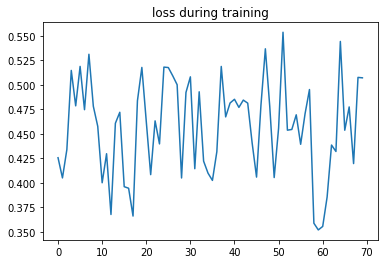

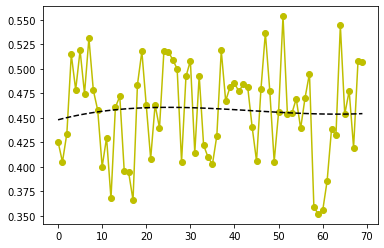

regression polynome :

           3            2
2.472e-07 x - 3.27e-05 x + 0.001171 x + 0.4482
started at 0.4257799154520035 and ended at 0.5073079357743263




In [ ]:
showData(losses, "loss during training", 3)

In [ ]:
evaluation_model = Tester(training_model.model)
accuracyResults, y_pred, y, correctPreds, incorrectPreds = evaluation_model.evaluateWithMetric(supportSet, querySet)

_, _, confM = getMatrixReport(y, y_pred)
print(accuracyResults)
print(confM)




 accuracy :32.0
[[ 6  4  4  1  0]
 [ 6  4  5  0  0]
 [ 1  1 12  1  0]
 [ 9  4  1  1  0]
 [ 2  3  8  1  1]]


# --- STATS ---

In [ ]:
listOfExperiences5 = [
                     ["(Adam, 1E-3), 3h1o (512, 240)..(240, 1)), Pre-done, 350x350, BCELoss, 70 epochs: ", 41, 40, 30.66, 34.66, 26.66],
                     ["(Adam, 1E-3), 3h1o (512, 240)..(240, 1)), Random  , 350x350, BCELoss, 70 epochs: ", 38.67, 26.67, 34.67, 38.67, 45],
                     ["(Adam, 1E-3), 3h1o (2048, 1024)..(1024, 1)), Random, 224x224, BCELoss, 70 epochs, normalized: ", 62.67, 50.67, 45.33, 54.67, 52],
                     ["(Adam, 1E-3), 3h1o (2048, 1024)..(1024, 1)), Random, 224x224, MSELoss, 70 epochs, normalized, representation, Omni ", 77.33, 77.33, 78.67, 77.33],
                     ["(Adam, 1E-3), 3h1o (2048, 1024)..(1024, 1)), Random, 224x224, MSELoss, 70 epochs, normalized, representation, Omni with reset ", 94.67, 86.67, 72],
                     ["(Adam, 1E-3), 3h1o (4096, 2048)..(2048, 1)) [use cat], Random, 224x224, BCELoss, 70 epochs, normalized, representation", 0, 0, 0, 0, 0]

                    ]
listOfExperiences6 = [
                      ["(Adam, 1E-3), 3h1o (2048, 1024)..(1024, 1)), Random, 224x224, BCELoss, 70 epochs, normalized, representation: ", 60, 53.33, 72, 46.67, 53.33, 42.67],
                      ["(Adam, 1E-3), 3h1o (2048, 1024)..(1024, 1)), Random, 224x224, BCELoss, 70 epochs, normalized, representation, Omni: ", 84, 74.67, 92, 77.33, 76, 68]
                      ]

listOfExperiences7 = [
                      ["(Adam, 1E-3), 3h1o (2048, 1024)..(1024, 1)), Random, 350x350, BCELoss, 70 epochs: ", 48, 46.67, 48, 41.33, 49, 42, 40]
                      ]

TotalList = [listOfExperiences5,
             listOfExperiences6, 
             listOfExperiences7
            ]

In [ ]:
createHistogramPreds(correctPreds, "prediction's score (correct)")
createHistogramPreds(incorrectPreds, "prediction's score (incorrect)")
createHistogramPreds(correctPreds+incorrectPreds, "total perdictions")

In [ ]:
getUaList(listOfExperiences5, 2.776)
getUaList(listOfExperiences6, 1.945)
getUaList(listOfExperiences7, 1.895)

In [ ]:
for listExp in TotalList:
  for x in listExp:
    plt.hist(x[1:])
    plt.title(x[0])
    plt.show()

#--- ACTUAL PIPELINE ---

##--- IMAGE RETRIEVAL ---

In [ ]:
classesFile = open(PATH_MODEL+"animals.txt")
classes = createListOfClasses(classesFile)
print("classes :", classes)

retreivalNotDone = True
if retreivalNotDone:
  getClassesImagesURLLIB(classes, retreivalNotDone)

classes : ['Aardvark', 'Aardwolf', 'Africanbuffalo', 'Africanelephant', 'Africanleopard', 'Albatross', 'Alligator', 'Alpaca', 'Americanrobin', 'Amphibian', 'Anaconda', 'Angelfish', 'Anglerfish', 'Ant', 'Anteater', 'Antelope', 'Antlion', 'Ape', 'Aphid']
downloading images...


100%|██████████| 19/19 [00:53<00:00,  2.81s/it]


380 images were downloaded. 20.0 per classes


##--- CLEANING ---

In [ ]:
provider = CleaningSetProvider(PATH_DATA, 10, 2)
meta_set = provider.getSetOfCleaningSets(['Amphibian']) #[classes[random.randint(0, len(classes)-1)]])

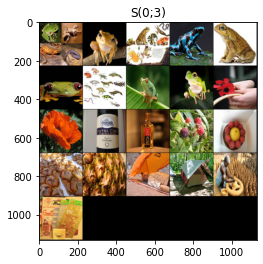

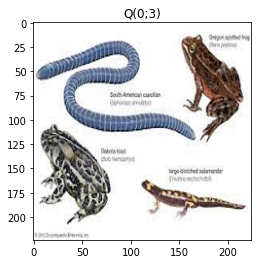

In [ ]:
if showDataClean:
  rows, columns = meta_set.lenght()

  i, j = random.randint(0, rows-1), random.randint(0, columns-1) 
  justSupport = getOnlyImages([meta_set(i, j)[0]])
  plot_images(justSupport, title="S("+str(i)+";"+str(j)+")", images_per_row=N_SHOT)
  plot_images(meta_set(i, j)[1][0], title="Q("+str(i)+";"+str(j)+")", images_per_row=1)

In [ ]:
cleaner = Cleaner(PATH_MODEL, modelCleaning, meta_set)
cleaner.cleanSets()

Traning on Set 0:  90%|█████████ | 63/70 [09:36<01:06,  9.56s/it]

In [ ]:
# for amphibian
rList = [8.5, 0.0, 0.26666666666666666, 3.75, 0.0, -1, 0.05555555555555555, -1, 0.0, 0.0, 0.0, 8.5, 0.0, 0.0, 0.5833333333333334, 0.05555555555555555, 0.5833333333333334, 0.05555555555555555, 18.0, 1.1111111111111112]

##--- TRAINING ---

In [ ]:
def getMin(supportClasses):
  """
  because cleaning classes do not have the same number of elements anymore,
  thus there's the need to avoid getting an out of range error
  """
  lenghts = []
  for pathToClass in supportClasses:
    lenghts.append(len(os.listdir(pathToClass)))

  return min(lenghts)

In [ ]:
supportClasses = [PATH_DATA+class_+"/" for class_ in classes]
N_SHOT = getMin(supportClasses)
supportSet, _ = getSets(supportClasses, N_SHOT, 0) 

In [ ]:
print("N_SHOT IS CONFIGURED TO BE", N_SHOT)

N_SHOT IS CONFIGURED TO BE 3


In [ ]:
showDataTrain = True
if showDataTrain:
  justSupport = getOnlyImages(supportSet)
  plot_images(justSupport, title="support set", images_per_row=N_SHOT)

In [ ]:
training_model = Trainer(PATH_MODEL, model, False)
training_model.training(supportSet, (0, 0), 0)

## --- EVALUATION ---

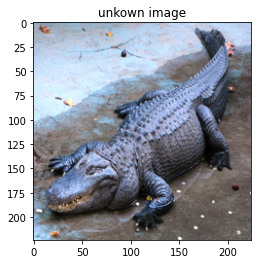

In [ ]:
PATH_TO_UNKNOWN = "/content/drive/MyDrive/Colab Notebooks/pipeline/unkown image/"
queries = os.listdir(PATH_TO_UNKNOWN)
query = getImageTensor(PATH_TO_UNKNOWN+queries[random.randint(0, len(queries)-1)]).unsqueeze(0)
plot_images(query, title="unkown image", images_per_row=1)

In [ ]:
evaluation_model = Tester(training_model.model)
predictedLabel = evaluation_model.queryEvaluation(supportSet, [query])

In [ ]:
print("Image of "+classes[predictedLabel]) # possible error with classes[predictedLabel] to check thourougly